# An Analysis of Pakistani Homes
## 1. Introduction
We will be describing machine learning methods used on a large dataset to analyze the
housing market in multiple cities in Pakistan. Pakistan is a very populous country, currently
having the fifth-highest population out of all countries. The country has more than 220 million
people with a yearly growth rate of 2%. This yearly change is on the higher end. For comparison,
the rates of the three most populous countries, China, India, and the United States are 0.39%,
0.99%, and 0.59% respectively. It is clear to see that the housing market in Pakistan is
expanding, and will continue to expand. Understanding the trends in this market, and which
factors cause those trends, is essential for the Pakistani Government, land developers, real estate
agencies, and real estate investors.

The goal of my analysis is to compare the performance of different machine learning
models, all predicting the prices of houses based on known factors. We will build different types
of models and see how the results compare. We will also look at how different factors impact the
price of a house, and which factors, in particular, are the most impactful, and the least impactful.
The following machine learning methods will be tested throughout this paper: Multiple Linear
Regression, Quadratic Regression, K-Nearest Neighbors, Decision Trees, and Random Forest.
We will split our data into disjoint training and testing sets in order to have accurate assessments
and reliable results. This will allow us to fairly judge the performance of a specific model.
Whenever possible, we will try to employ techniques to improve the quality of our model.
### Imports

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn.linear_model as linMod
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
import sklearn.tree as tree
from sklearn.tree import DecisionTreeRegressor

from scipy import stats

housesRaw = pd.read_csv('Entities.csv')

## 2. Dataset
The dataset we are using was scraped by Huzefa Khan from a popular Pakistani real
estate website, Zameen.com, and uploaded to Open Data Pakistan and Kaggle. “Zameen” is an
Urdu and Hindi word that translates to “ground” or “land”. The dataset we are using contains
almost 170,000 instances of data. Originally the dataset contained 18 columns, some were
unnecessary for our purposes. The columns in the original dataset are as follows.

- INT property_id: A unique ID given to each house by Zameen.com
- INT location_id: An ID given to each plot by Zameen.com
- STRING page_url: Link where listing was posted
- STRING property_type: Type of property (‘House’, ‘Farm House’, ‘Flat’, ‘Upper
Portion’, ‘Lower Portion’, ‘Room’, ‘Penthouse’)
- INT price: For Sale or For Rent price in Pakistani Rupees
- STRING location: Block/street name
- STRING city: City name (‘Karachi’, ‘Lahore’, ‘Islamabad’, ‘Rawalpindi’, ‘Faisalabad’)
- STRING province_name: Province/state name (‘Sindh’, ‘Punjab’, ‘Islamabad Capital’)
- FLOAT latitude: Latitude coordinate
- FLOAT longitude: Longitude coordinate
- INT baths: Number of bathrooms
- STRING purpose: Purpose of listing (‘For Sale’, ‘For Rent’)
- INT bedrooms: Number of bedrooms
- STRING date_added: The listing date on Zameen.com
- STRING agency: Company selling property
- STRING agent: Property dealer
- FLOAT Total_Area: Property area in square feet

I dropped some of the columns I found to be unnecessary e,g ‘page_url’, ‘agency’,
‘agent’, ‘date_added’, ‘location’ (since there are too many street names to keep track of. Not
enough properties share the same street name, therefore will not help us in our analysis),
‘purpose’ (because we will only be looking at properties that are ‘For Sale’), ‘property_id’, and
‘location_id’. The target column is the ‘price’ of the house given in Pakistani Rupees (PKR). The
cleaned dataset contains the following columns.

- STRING type: Type of property (‘House’, ‘Farm House’, ‘Flat’, ‘Upper Portion’, ‘Lower Portion’, ‘Room’, ‘Penthouse’)
- INT bedrooms: Number of bedrooms
- INT baths: Number of bathrooms
- FLOAT area: Property area in square feet
- STRING city: City name (‘Karachi’, ‘Lahore’, ‘Islamabad’, ‘Rawalpindi’, ‘Faisalabad’)
- STRING province: Province/state name (‘Sindh’, ‘Punjab’, ‘Islamabad Capital’)
- FLOAT latitude: Latitude coordinate
- FLOAT longitude: Longitude coordinate
- INT price: For sale or for rent price in Pakistani Rupees.

Many datasets are prone to human error, including this one. Human error can be
introduced by Zameen.com when entering values or during the process of web scraping. The
dataset contains entries that have 0 bedrooms, 0 baths, and 0 square feet. These entries were
dropped since they don’t make sense in our context. We also removed a few entries that were
outliers. There were many outliers in terms of ‘price’, ‘bedrooms’, ‘bathrooms’, and ‘area’ that
would skew our models if not removed. We begin by exploring the overall data in the hopes of
finding patterns. Below we have multiple plots of various predictors compared against price. We
want to see if there exists any relationship between the price and any of the predictors.
### Clean up data

In [22]:
# Copy and filter housesRaw and print
housesClean = housesRaw[['property_type', 'purpose', 'bedrooms',
                        'baths', 'Total_Area', 'city', 'province_name',
                         'latitude', 'longitude', 'price']].rename(
    columns={'Total_Area': 'area', 'property_type': 'type', 'province_name': 'province'})

housesClean = housesClean[housesClean.baths != 0]
housesClean = housesClean[housesClean.bedrooms != 0]
housesClean = housesClean[housesClean.area != 0]
housesClean = housesClean[housesClean.purpose == 'For Sale']

housesClean = housesClean.drop(['purpose'], axis=1)

# Remove Outliers
housesClean = housesClean[(
    np.abs(stats.zscore(housesClean['area'])) < 3)]
housesClean = housesClean[(
    np.abs(stats.zscore(housesClean['bedrooms'])) < 3)]
housesClean = housesClean[(
    np.abs(stats.zscore(housesClean['baths'])) < 3)]
housesClean = housesClean[(
    np.abs(stats.zscore(housesClean['price'])) < 3)]

colors = {'Karachi': 'red', 'Lahore': 'blue', 'Islamabad': 'green',
          'Faisalabad': 'yellow', 'Rawalpindi': 'purple'}

housesClean

,type,bedrooms,baths,area,city,province,latitude,longitude,price
0,Flat,2,2,1089.004,Islamabad,Islamabad Capital,33.679890,73.012640,10000000
1,Flat,3,3,15246.056,Islamabad,Islamabad Capital,33.700993,72.971492,6900000
2,House,5,6,2178.008,Islamabad,Islamabad Capital,33.631486,72.926559,16500000
3,House,4,4,10890.000,Islamabad,Islamabad Capital,33.707573,73.151199,43500000
4,House,3,3,2178.008,Islamabad,Islamabad Capital,33.492591,73.301339,7000000
...,...,...,...,...,...,...,...,...,...
168436,House,3,4,2178.008,Karachi,Sindh,25.071948,67.338656,8800000
168437,House,3,4,1361.255,Karachi,Sindh,25.067079,67.309986,5000000
168438,House,3,3,2178.008,Karachi,Sindh,25.058062,67.306626,14000000
168439,House,4,4,3811.514,Karachi,Sindh,25.005740,67.316385,14000000


### Visualize data
#### Pairplot (divided into 2 for easy viewing)

C:\Users\HashmatAli\AppData\Local\Temp\ipykernel_13216\318137420.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation=45)


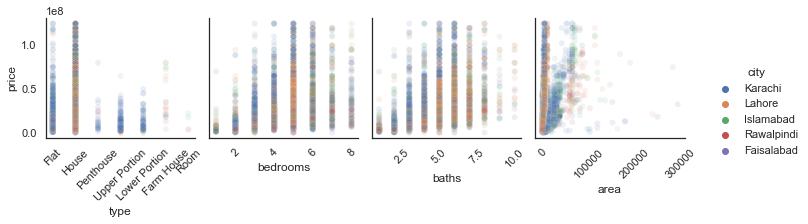

C:\Users\HashmatAli\AppData\Local\Temp\ipykernel_13216\318137420.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(axis.get_xticklabels(), rotation=45)


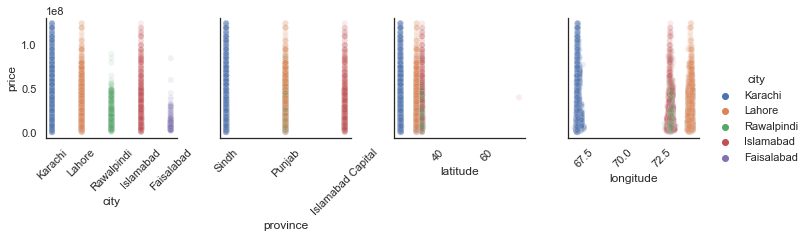

In [4]:
sns.set(style='white', font_scale=1, color_codes=True)

maxPrice = housesClean['price'].max()
upperY = maxPrice*1.25


pair = sns.pairplot(housesClean.sample(10000),
                    plot_kws={'alpha': 0.1},
                    x_vars=['type', 'bedrooms', 'baths', 'area'],
                    y_vars=['price'],
                    hue='city')
for axis in pair.fig.axes:
    axis.set_xticklabels(axis.get_xticklabels(), rotation=45)
plt.show()

pair = sns.pairplot(housesClean.sample(10000),
                    plot_kws={'alpha': 0.1},
                    x_vars=['city', 'province', 'latitude', 'longitude'],
                    y_vars=['price'],
                    hue='city')
for axis in pair.fig.axes:
    axis.set_xticklabels(axis.get_xticklabels(), rotation=45)
plt.show()

From the above plots, I can see there is a correlation between ‘bathrooms’ and ‘price’,
‘bedrooms’ and ‘price’, and between ‘area’ and ‘price’. Below are plots for multiple predictors against 'price'. The plot for ‘area’ compared to
‘price’ is given with a regression line to give us an idea of the trend.
#### Bedrooms x Price

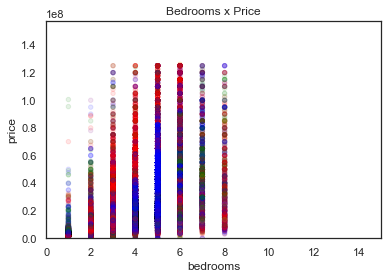

In [5]:
housesClean.plot(x='bedrooms',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.xlim([0, 15])
plt.ylim([0, upperY])
plt.title('Bedrooms x Price')
plt.show()

#### Bathrooms x Price

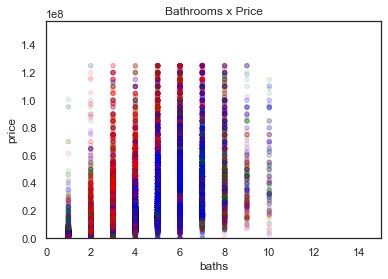

In [6]:
housesClean.plot(x='baths',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.xlim([0, 15])
plt.ylim([0, upperY])
plt.title('Bathrooms x Price')
plt.show()

#### Area x Price

C:\Users\HashmatAli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


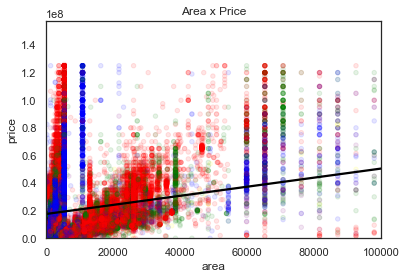

In [7]:
housesClean.plot(x='area',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.xlim([0, 100000])
plt.ylim([0, upperY])
sns.regplot(housesClean.area, housesClean.price, order=1,
            ci=None, scatter=False, color='black')
plt.title('Area x Price')
plt.show()

#### City x Price

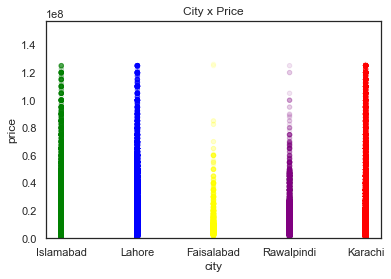

In [8]:
housesClean.plot(x='city',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.ylim([0, upperY])
plt.title('City x Price')
plt.show()

#### Type x Price

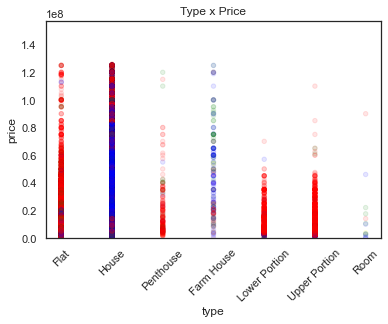

In [9]:
housesClean.plot(x='type',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.ylim([0, upperY])
plt.title('Type x Price')
plt.xticks(rotation=45)
plt.show()

#### Province x Price

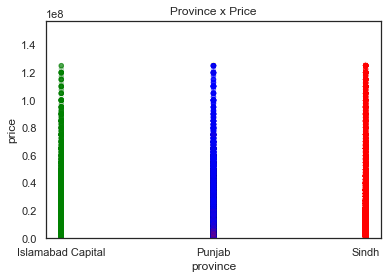

In [10]:
housesClean.plot(x='province',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.ylim([0, upperY])
plt.title('Province x Price')
plt.show()

We can see, in general, the price of a property increases as the number of bedrooms and
bathrooms increases. After the 6th or 7th bedroom or bathroom, the price begins to plateau. Also a
note on the price axis: The Pakistani Rupee has undergone a lot of inflation. The value of the
Pakistani Rupee is very low compared to the United States Dollar. The relationship between the
two is 1 USD = 179.46 PKR at the of writing. This explains the large scale for the price axis. We
can see, especially towards the lower end of the area plot, that the graph “splits” into two
directions. This shows us that area, overall, has a relationship with price, but other factors also
have an impact. Another thing to notice is the prices of houses in Rawalpindi and Faisalabad are
lower than those in Lahore, Karachi, or Islamabad. This is because Lahore, Karachi, and
Islamabad are much more industrial cities. After undergoing One Hot Encoding, we come up
with the following correlation heat map.
#### One Hot Encoding

In [11]:
housesClean = pd.get_dummies(
    data=housesClean, drop_first=True).rename(
    columns={'type_Lower Portion': 'type_Lower_Portion',
             'type_Upper Portion': 'type_Upper_Portion',
             'purpose_For Sale': 'purpose_For_Sale'})

print(housesClean)

        bedrooms  baths       area   latitude  longitude     price  type_Flat  \
0              2      2   1089.004  33.679890  73.012640  10000000          1   
1              3      3  15246.056  33.700993  72.971492   6900000          1   
2              5      6   2178.008  33.631486  72.926559  16500000          0   
3              4      4  10890.000  33.707573  73.151199  43500000          0   
4              3      3   2178.008  33.492591  73.301339   7000000          0   
...          ...    ...        ...        ...        ...       ...        ...   
168436         3      4   2178.008  25.071948  67.338656   8800000          0   
168437         3      4   1361.255  25.067079  67.309986   5000000          0   
168438         3      3   2178.008  25.058062  67.306626  14000000          0   
168439         4      4   3811.514  25.005740  67.316385  14000000          0   
168445         3      3  25591.594  25.113565  67.353811   9000000          0   

        type_House  type_Lo

#### Correlation Heat Map

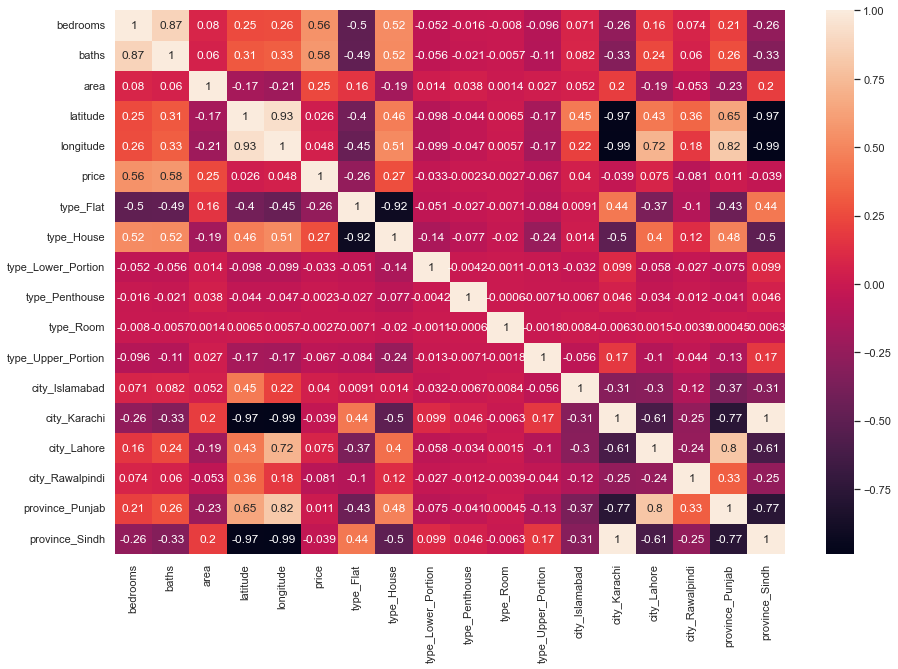

In [12]:
plt.figure(figsize=(15, 10))
sns.heatmap(housesClean.corr(), annot=True)
plt.show()

## 3. Analysis
Many different models can be used in regression situations. We start
by splitting our data into disjoint training and testing sets. This is to ensure we are getting good
results. I reserve 20% of the data for testing.
#### Train Test Split

In [13]:
X = housesClean.drop(columns='price')
y = housesClean['price']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2)

### 3.1 Multiple Linear Regression
#### Linear Regression
We begin by using Multiple Linear Regression to predict the prices on various properties.
Linear Regression is simple to implement and is not as complex as other models. Linear
Regression can be impacted by outliers, which is why we removed outliers from our dataset.
Using Multiple Linear Regression, “sklearn.linear_model.LinearRegression()”, our model
achieves an R-squared score of 0.409 with an intercept of 133230926.52 and coefficients of
[2.65e+06, 4.87e+06 2.51e+02, -3.75e+06, -2.93e+05, -1.16e+07, -8.42e+06, -1.34e+07,
-1.19e+07, -7.09e+06, -1.44e+07, 1.20e+07, -8.83e+06, 7.17e+06, 8.26e+06, -3.14e+06,
-8.83e+06].


In [20]:
print("Multiple Linear Regression")
linRegress = linMod.LinearRegression()
linRegress.fit(Xtrain, ytrain)
print("Linear R2:", r2_score(ytest, linRegress.predict(Xtest)))
print(linRegress.coef_)
print(linRegress.intercept_)

Multiple Linear Regression
Linear R2: 0.4039806513238994
[ 2.75516258e+06  4.75986426e+06  2.60678476e+02 -2.30789572e+06
  9.43310277e+04 -9.50029639e+06 -6.48804972e+06 -1.14920703e+07
 -9.65730206e+06 -4.77911030e+06 -1.20960073e+07  7.81226391e+06
 -3.63150079e+06  6.67355930e+06  5.23927711e+06 -4.18076312e+06
 -3.63150079e+06]
58700819.95891835


#### Polynomial Regression
Next, we try to make a more complex model with higher degrees of freedom in the hopes
that our model will fit the data better. First, I take the first three principal components of the data
set. This is done using “sklearn.decomposition.PCA(n_components=3)”. Then we fit a Quadratic
Regression model to it. A Quadratic Regression model is a Polynomial Regression model with
degree = 2. This is done by calling “sklearn.preprocessing.PolynomialFeatures(degree = 2)”. The
results are slightly better. We get an R-squared score of 0.420. Our intercept is 20266031.50 and
our coefficients are
[0, 4.05e+02, 5.75e+05, -5.77e+06, -1.12e-03, 1.43e+01, -1.77e+01, 5.33e+03, 2.08e+05,
6.65e+04].

In [14]:
# Principal Component Analysis
pca = PCA(n_components=3)
XtrainPCA = pca.fit_transform(Xtrain)
XtestPCA = pca.fit_transform(Xtest)

# Polynomial Regression deg=2
print("Polynomial Regression deg=2")
poly = PolynomialFeatures(degree=2)
XtrainP = poly.fit_transform(XtrainPCA)
XtestP = poly.fit_transform(XtestPCA)
polyRegress = linMod.LinearRegression().fit(XtrainP, ytrain)

print("Quad R2:", r2_score(ytest, polyRegress.predict(XtestP)))
print(polyRegress.coef_)
print(polyRegress.intercept_)

Polynomial Regression deg=2
Quad R2: 0.36372908857970265
[ 0.00000000e+00  4.38146553e+02  5.01390787e+05 -5.82722756e+06
 -1.71469358e-03  1.94087772e+01 -1.06040285e+01 -2.95236476e+04
  2.04772235e+05  7.45649736e+04]
21226984.01225426


### 3.2 K-Nearest Neighbors Regression Methods
#### Minkowski metric
Next, we use K-Nearest Neighbors. K-Nearest Neighbors is another simple model that is
easy to implement. One benefit this model has over Linear Regression is that K-Nearest
Neighbors is non-parametric, meaning it has no assumption about the data. Linear Regression
assumes the predictors have a linear relationship to the target. This model is also sensitive to
outliers, but we don’t need to worry about that. We start with default settings by calling
“KNeighborsRegressor()”. Our k = 5 (by default) and our distance metric is the “Minkowski
distance” (by default). Using K-nearest neighbors, we already see better results compared to
Multiple Linear Regression. With no alterations made, we achieve an R-squared score of 0.859.

K-Nearest R2: 0.8517966056401706
Best K value (Minkowski) is 4
Best R2 score (Minkowski) is 0.8533161017823624


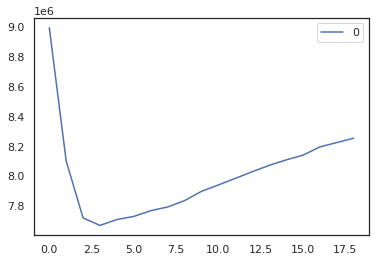

In [15]:
KNN = KNeighborsRegressor()
KNN.fit(Xtrain, ytrain)

print("K-Nearest R2:", r2_score(ytest, KNN.predict(Xtest)))

# Test different K values in K Nearest Neighbors

rmse_val = []
BestK = 0
BestR2 = 0

for K in range(1, 20):
    KNN = KNeighborsRegressor(n_neighbors=K)
    KNN.fit(Xtrain, ytrain)
    error = np.sqrt(mean_squared_error(
        ytest, KNN.predict(Xtest)))  # calculate rmse
    rmse_val.append(error)  # store rmse values

    if r2_score(ytest, KNN.predict(Xtest)) > BestR2:  # Update best K value so far
        BestR2 = r2_score(ytest, KNN.predict(Xtest))
        BestK = K

print('Best K value (Minkowski) is', BestK)
print('Best R2 score (Minkowski) is', BestR2)

curve = pd.DataFrame(rmse_val)  # elbow curve
curve.plot()
plt.show()

#### Manhattan metric
We want to see if we can improve this model. Next, we will iterate over a range of k and
use both the “Minkowski distance” and the “Manhattan distance”. I created a KNN loop that
tests all integers from 1 to 20. We did not test any higher k values, revealing one of the flaws of
K-Nearest Neighbors, it is very computationally expensive. For the “Minkowski distance”, we
find that a k = 4 or 5 is ideal, giving us a similar R-squared score as above. For the “Manhattan
distance” we find the same result. Changing the distance metric did not impact our model. Below
we have elbow graphs charting k to RMSE.

Best K value (Manhattan) is 4
Best R2 score (Manhattan) is 0.8539661778109127


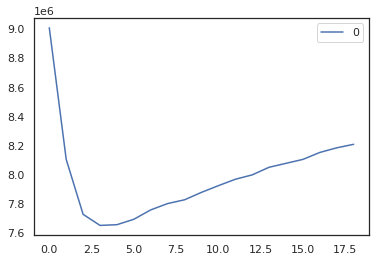

In [16]:
rmse_val = []
BestK = 0
BestR2 = 0

for K in range(1, 20):
    KNN = KNeighborsRegressor(n_neighbors=K, metric='manhattan')
    KNN.fit(Xtrain, ytrain)
    error = np.sqrt(mean_squared_error(
        ytest, KNN.predict(Xtest)))  # calculate rmse
    rmse_val.append(error)  # store rmse values

    if r2_score(ytest, KNN.predict(Xtest)) > BestR2:  # Update best K value so far
        BestR2 = r2_score(ytest, KNN.predict(Xtest))
        BestK = K

print('Best K value (Manhattan) is', BestK)
print('Best R2 score (Manhattan) is', BestR2)

curve = pd.DataFrame(rmse_val)  # elbow curve
curve.plot()
plt.show()

### 3.3 Decision Trees Methods
#### Decision Tree Regression
Next, we will discuss Decision Trees. Decision Trees are not as easily influenced by
outliers as Linear Regression of K-Nearest Neighbors. Like K-Nearest Neighbors, Decision
Trees are non-parametric and will not make assumptions about the data. First, we start with a
standard Decision Tree using “DecisionTreeRegressor()”. Without setting a ‘max_leaf_node’, we
allow the method to run indefinitely. This can cause overfitting. With our current model, we
achieve an R-squared score of 0.87. Even with overfitting, this model outperforms K-Nearest
Neighbors.

In [17]:
treeRegress = DecisionTreeRegressor()
treeRegress.fit(Xtrain, ytrain)

print("Decision Tree R2:", r2_score(ytest, treeRegress.predict(Xtest)))

Decision Tree R2: 0.841590874701682


#### Random Forest Regression
Our model can still be improved. Using Random Forest, we can create an even more
accurate model. Random Forest, in general, performs better since this method creates multiple
Decision Trees and then takes the majority vote from all of them. By calling
“sklearn.ensemble.RandomForestRegressor()”, we can create our model. Running this model
gives us an R-squared score of 0.91. This is the highest score we have achieved out of all the
methods we have tried.

In [18]:
RFRegress = RandomForestRegressor()
RFRegress.fit(Xtrain, ytrain)

print("Random Forest R2:", r2_score(ytest, RFRegress.predict(Xtest)))

Random Forest R2: 0.8924122922331668


## 4. Conclusion
Throughout this paper, we used various types of models to assess the Pakistani house
price dataset. From our pre-analysis steps, we found that the number of bedrooms and the
number of bathrooms had a positive correlation to price. We also found that the property area
was positively correlated to price. After experimenting with many different models, we found
that Linear Regression was not well suited for this dataset. Linear models assumed the predictors
had a linear correlation with the target. It turns out that this was not the case. Simple Linear
Regression achieved the lowest performance out of all the methods we tried. Quadratic
Regression slightly increased performance, but not by much. Using K-Nearest Neighbors
Regression, we had a significant increase in accuracy. Trying different values for k, and trying
different metrics, we conclude that k = 4 or 5 yields the best result. Lastly, we used decision trees
to make predictions. Using a simple decision tree we again saw an increase in accuracy. Random
Forest achieved the highest accuracy out of all of our models with an R-squared score of 0.91.
All this being said, we now understand the main factors that determine house prices in Pakistan,
and how we can accurately predict them.